# 04 Reach Overlap Simulation
Estimate deduplicated (unique) audience reach across channels given
spend allocations, CPMs, and overlap matrix.
Outputs a function `deduped_reach()` for later optimization.

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

campaign = pd.read_csv("../data/processed/campaign_daily_processed.csv")
overlap_df = pd.read_csv("../data/raw/overlap_matrix.csv")
print("Campaign:", campaign.shape, "Overlap:", overlap_df.shape)
campaign.head()
overlap_df.head()

Campaign: (1825, 12) Overlap: (10, 3)


,ch_i,ch_j,overlap_rate
0,LinearTV,Streaming,0.100
1,LinearTV,YouTube,0.228
2,LinearTV,Display,0.194
3,LinearTV,Social,0.065
4,Streaming,YouTube,0.214


In [2]:
def reach_from_impressions(impressions, A=1.0, k=1e-7):
    """Convert impressions → fractional audience reach."""
    return A * (1 - np.exp(-k * impressions))

In [3]:
def deduped_reach(spend_dict, cpm_dict, overlap_df, A=1.0, k=1e-7):
    """
    Estimate total deduped reach (fraction of audience) for a spend allocation.

    spend_dict:  {'Streaming': 300000, ...}
    cpm_dict:    {'Streaming': 18, ...}
    overlap_df:  DataFrame with ch_i, ch_j, overlap_rate
    """
    channels = list(spend_dict.keys())
    reach_each = {}

    # individual reach fractions
    for ch in channels:
        impressions = (spend_dict[ch] / cpm_dict[ch]) * 1000
        reach_each[ch] = reach_from_impressions(impressions, A, k)

    # total raw reach
    total = sum(reach_each.values())

    # subtract pairwise overlaps
    for _, row in overlap_df.iterrows():
        ci, cj, ov = row
        if ci in reach_each and cj in reach_each:
            total -= ov * min(reach_each[ci], reach_each[cj])

    # ensure not negative or >1
    return np.clip(total, 0, A)

In [4]:
channels = ["LinearTV","Streaming","YouTube","Display","Social"]
cpm_dict = {
    "LinearTV":25,"Streaming":18,"YouTube":12,"Display":8,"Social":6
}

# Example baseline spend distribution
spend_test = {
    "LinearTV": 300000,
    "Streaming": 250000,
    "YouTube": 150000,
    "Display": 100000,
    "Social": 200000
}

R = deduped_reach(spend_test, cpm_dict, overlap_df, A=0.8, k=1e-7)
print(f"Estimated deduped reach fraction: {R:.3f}")
print(f"Unique audience reached (~people): {R*1_000_000:,.0f}")

Estimated deduped reach fraction: 0.800
Unique audience reached (~people): 800,000


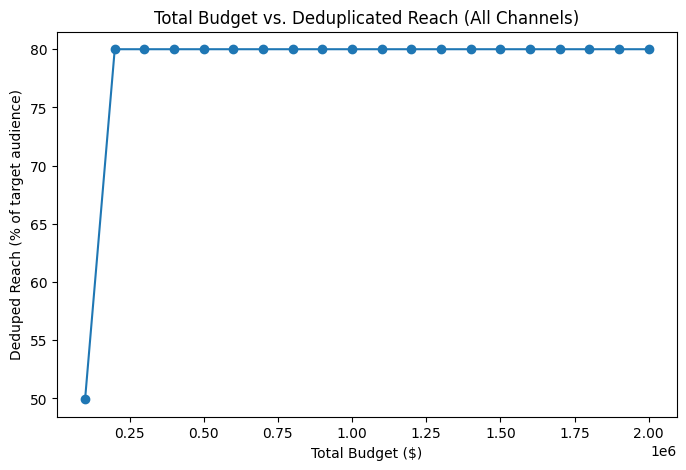

In [5]:
total_budget = np.linspace(100000, 2_000_000, 20)
deduped_reaches = []

for b in total_budget:
    # equal allocation across channels
    sdict = {ch: b/len(channels) for ch in channels}
    deduped_reaches.append(deduped_reach(sdict, cpm_dict, overlap_df, A=0.8, k=1e-7))

plt.figure(figsize=(8,5))
plt.plot(total_budget, np.array(deduped_reaches)*100, marker='o')
plt.xlabel("Total Budget ($)")
plt.ylabel("Deduped Reach (% of target audience)")
plt.title("Total Budget vs. Deduplicated Reach (All Channels)")
plt.show()

In [6]:
reach_results = pd.DataFrame({
    "total_budget": total_budget,
    "deduped_reach_pct": np.array(deduped_reaches)*100
})
reach_results.to_csv("../data/processed/reach_budget_curve.csv", index=False)
print("✅ Saved reach_budget_curve.csv")

✅ Saved reach_budget_curve.csv
